This code addresses [Issue #16](https://github.com/pavelkomarov/spectral-derivatives/issues/16).

Essentially, `spec_deriv`, `math.pdf`, [Trefethen himself](https://epubs.siam.org/doi/epdf/10.1137/1.9780898719598.ch8) are overcomplicating taking derivatives with the Chebyshev basis, and we can obviate a lot of steps.

0 8.429731597374347e-30 5.719287779152547e-31 
1 4.1903649122814733e-19 4.190401496034697e-19 4.1169996844132876e-19
2 2.10892451086177e-05 2.1089245108302867e-05 2.1261024253153883e-05
3 285453051.72875345 285453051.7267138 59638151.851370886
4 1.6448632027710557e+21 1.644863202758878e+21 5.8885627500520944e+20


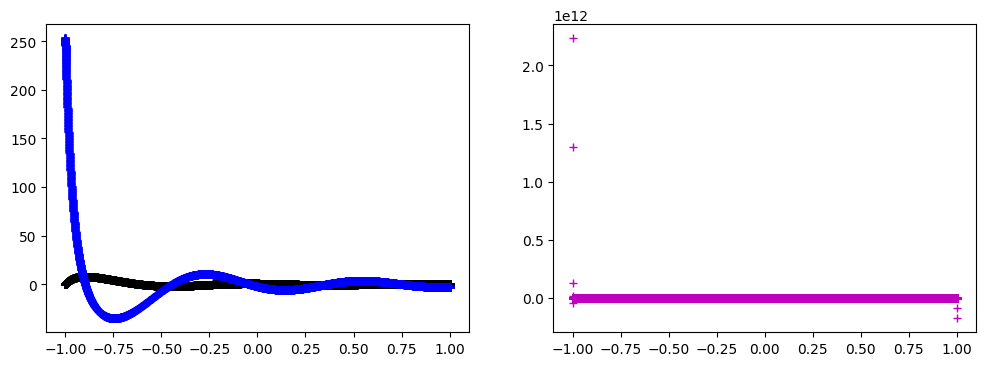

In [24]:
import numpy as np
from numpy.polynomial.chebyshev import Chebyshev
from matplotlib import pyplot
from scipy.fft import dct, dst
from specderiv import cheb_deriv

N = 4096

x_n = np.cos(np.arange(N+1) * np.pi / N)
x = np.linspace(-1, 1, 100)

y = lambda x: np.sin(8*(x+1))/((x + 1.1)**(3/2))
dy = lambda x: ((8.8 + 8*x)*np.cos(8*(x+1)) - 1.5*np.sin(8*(x+1)))/((x + 1.1)**(5/2))
d2y = lambda x: ((-26.4 - 24*x)*np.cos(8 + 8*x) + (-73.69 + (-140.8 - 64*x)*x)*np.sin(8 + 8*x))/((1.1 + x)**(7/2))
d3y = lambda x: ((-582.472 + x*(-1768.56 + (-1689.6 - 512*x)*x))*np.cos(8 + 8*x) + (335.355 + x*(633.6 + 288.*x))*np.sin(8 + 8*x))/((1.1 + x)**(9/2))
d4y = lambda x: ((3626.83 + x*(10731.4 + x*(10137.6 + 3072*x)))*np.cos(8 + 8*x) + (4313.62 + x*(18639.1 + x*(28297. + x*(18022.4 + 4096*x))))*np.sin(8 + 8*x))/((1.1 + x)**(11/2))

#y = lambda x: np.exp(x) * np.sin(5*x)
#dy = lambda x: 5*np.exp(x) * np.cos(5*x) + np.exp(x) * np.sin(5*x)
#d2y = lambda x: 2*np.exp(x) * (5*np.cos(5*x) - 12*np.sin(5*x))
#d3y = lambda x: -2*np.exp(x) * (37*np.sin(5*x) + 55*np.cos(5*x))
#d4y = lambda x: 4*np.exp(x) * (119*np.sin(5*x) - 120*np.cos(5*x))

y_n = y(x_n)
Y_k = dct(y_n, 1)
Y_k[0] /= 2; Y_k[N] /= 2 # because first and last coefficients are outside the sum
Y_k /= N # In IDCT-I we divide by N
cheb = Chebyshev(Y_k) # This class' deriv function works in O(N)
# No mapping back to chebyshev domain. No worrying about endpoint formulas.

def L2(w, v):
    """calculate L2 error squared"""
    return np.mean((w - v)**2)

y_n_primes = []
for nu,dy_ in enumerate([y, dy, d2y, d3y, d4y]):
    dcheb = cheb.deriv(nu) # O(nu * N) instead of O(N + nu^2 + nu * N)

    # Evaluating cheb(x) uses `chebval`, which is based on the recurrence formula, which works in O(cN), where c is the
    # number of coefficients, which will be another N in this case. We can avoid this O(N^2) with an inverse transform,
    # since our sample points are the Chebyshev points. We can construct the Y_k' necessary for such a transform from
    # the Chebyshev coefficients.
    Y_k_prime = np.concatenate((dcheb.coef*N, [0]*nu)) # always len N so we get N samples back after inverse transform
    Y_k_prime[0] *= 2; Y_k_prime[N] *= 2

    y_n_primes.append( dct(Y_k_prime, 1)/(2*N) ) # This is the O(N log N) way, via inverse transform

    dy_n = dy_(x_n)
    print(nu, L2(dy_n, dcheb(x_n)), L2(dy_n, y_n_primes[-1]), "" if nu == 0 else L2(dy_n, cheb_deriv(y_n, x_n, nu)))

fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
axes[0].plot(x, y(x), 'k')
axes[0].plot(x_n, y_n_primes[0], 'k+')
axes[0].plot(x, dy(x), 'b')
axes[0].plot(x_n, y_n_primes[1], 'b+')
axes[1].plot(x, d2y(x), 'r')
axes[1].plot(x_n, y_n_primes[2], 'r+')
axes[1].plot(x, d3y(x), 'g')
axes[1].plot(x_n, y_n_primes[3], 'g+')
axes[1].plot(x, d4y(x), 'm')
axes[1].plot(x_n, y_n_primes[4], 'm+');


We can actually do the DCT-II with this method also, because we can reach the same coefficients simply:

In [2]:
x_nII = np.concatenate(([1], np.cos((np.arange(N+1) + 0.5) * np.pi/(N+1)), [-1]))

y_nII = y(x_nII)
Y_kII = dct(y_nII[1:-1], 2)
Y_kII[0] /= 2 # because first element of DCT-III is outside the sum
Y_kII /= N+1 # IDCT-II has division by N+1

assert np.allclose(Y_k, Y_kII)

cheb = Chebyshev(Y_kII)
cheb_1 = cheb.deriv(1) # O(nu * N) instead of O(N + nu^2 + nu * N + N log N)
cheb_2 = cheb.deriv(2)
cheb_3 = cheb.deriv(3)
cheb_4 = cheb.deriv(4)

print("0", np.mean((y_nII - cheb(x_nII))**2))
print("1", np.mean((dy(x_nII) - cheb_1(x_nII))**2), np.mean((dy(x_nII) - cheb_deriv(y_nII, x_nII, 1, dct_type=2))**2))
print("2", np.mean((d2y(x_nII) - cheb_2(x_nII))**2), np.mean((d2y(x_nII) - cheb_deriv(y_nII, x_nII, 2, dct_type=2))**2))
print("3", np.mean((d3y(x_nII) - cheb_3(x_nII))**2), np.mean((d3y(x_nII) - cheb_deriv(y_nII, x_nII, 3, dct_type=2))**2))
print("4", np.mean((d4y(x_nII) - cheb_4(x_nII))**2), np.mean((d4y(x_nII) - cheb_deriv(y_nII, x_nII, 4, dct_type=2))**2))

0 3.906479119716537e-24
1 566219.1745550843 566219.1745550843
2 2.6220943503579212e-14 2.6220860666289068e-14
3 2.1545138192240087e-10 2.1544799361755951e-10
4 8.747607419613032e-07 8.745764380667108e-07
